In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install pyngrok --quiet
!pip install mlflow --quiet

import mlflow
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

# create remote tunnel using ngrok.com to allow local port access

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "1r8VzJGvVkDqYJDLNyNR12FZAIN_bYtBiBQEXBPv8DnzxKTB"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

def eval_metrics(actual, pred):
    acc = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    precision = precision_score(actual, pred)
    recall = recall_score(actual, pred)
    return acc, f1, precision, recall

def mlflow_save(params, metrics):
    with mlflow.start_run():
        for key, value in params.items():
            mlflow.log_param(key, value)

        mlflow.log_metric("accuracy", metrics[0])
        mlflow.log_metric("f1", metrics[1])
        mlflow.log_metric("precision", metrics[2])
        mlflow.log_metric("recall", metrics[3])

     |████████████████████████████████| 747kB 26.3MB/s 
     |████████████████████████████████| 14.2MB 290kB/s 
     |████████████████████████████████| 163kB 46.7MB/s 
     |████████████████████████████████| 378kB 41.2MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 153kB 48.3MB/s 
     |████████████████████████████████| 1.1MB 36.1MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
MLflow Tracking UI: https://97ed6405d2a9.ngrok.io


In [3]:
DEMO = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/DEMO_J.XPT', index='SEQN')
DEMO = DEMO[['RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'DMDMARTL']]

BMX = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/BMX_J.XPT', index='SEQN')
BMX = BMX[['BMXWT', 'BMXHT']]

BPX = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/BPX_J.XPT', index='SEQN') 
BPX = BPX[['BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2']]

BPQ = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/BPQ_J.XPT', index='SEQN') 
BPQ = BPQ[['BPQ020', 'BPQ080']]

df = pd.merge(DEMO, BMX, left_index=True, right_index=True, how='inner')
df = pd.merge(df, BPX, left_index=True, right_index=True, how='inner')
df = pd.merge(df, BPQ, left_index=True, right_index=True, how='inner')

df.columns = ['Gender','Age','Education','Marital','Weight','Height','Systole1','Diastole1','Systole2','Diastole2','High_Pressure','High_Cholesterol']
df.Gender = df.Gender.replace({1.0: 'Male', 2.0: 'Female'})
df.Education = df.Education.replace({1.0: '-9th', 2.0: '9-11th', 3.0: 'High School', 4.0: 'Some College', 5.0: 'Graduate+', 7.0: 'Refused', 8.0: 'Don\'t Know'})
df.Marital = df.Marital.replace({1.0: 'Married', 2.0: 'Widowed', 3.0: 'Divorced', 4.0: 'Separated', 5.0: 'Never Married', 6.0: 'Living With Partner', 77: 'Refused', 99: 'Don\'t Know'})
df.High_Pressure = df.High_Pressure.replace({1.0: 'Yes', 2.0: 'No', 7.0: 'Refused', 9.0: 'Don\'t Know'})
df.High_Cholesterol = df.High_Cholesterol.replace({1.0: 'Yes', 2.0: 'No', 7.0: 'Refused', 9.0: 'Don\'t Know'})
display(df.head())
df.shape

,Gender,Age,Education,Marital,Weight,Height,Systole1,Diastole1,Systole2,Diastole2,High_Pressure,High_Cholesterol
SEQN,,,,,,,,,,,,
93705.0,Female,66.0,9-11th,Divorced,79.5,158.3,NaN,NaN,NaN,NaN,Yes,No
93706.0,Male,18.0,NaN,NaN,66.3,175.7,112.0,74.0,114.0,70.0,No,No
93708.0,Female,66.0,-9th,Married,53.5,150.2,NaN,NaN,138.0,78.0,Yes,Yes
93709.0,Female,75.0,Some College,Widowed,88.8,151.1,120.0,66.0,118.0,66.0,Yes,No
93711.0,Male,56.0,Graduate+,Married,62.1,170.6,108.0,68.0,94.0,68.0,No,Yes


(5828, 12)

In [4]:
df = df[(df.High_Pressure.isin(['Yes','No'])) & (df.High_Cholesterol.isin(['Yes','No']))]
df = df.dropna()
df.shape

(4476, 12)

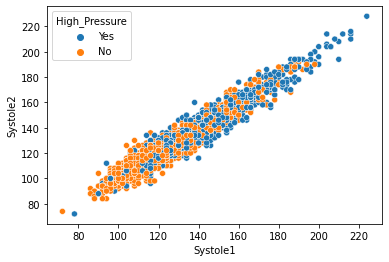

In [5]:
sns.scatterplot(data=df, x='Systole1', y='Systole2', hue='High_Pressure');

In [6]:
df['Gender'] = df['Gender'].astype('category')
df['Education'] = df['Education'].astype('category')
df['Marital'] = df['Marital'].astype('category')
df['High_Pressure'] = df['High_Pressure'].astype('category')
df['High_Cholesterol'] = df['High_Cholesterol'].astype('category')

df['Gender'] = df['Gender'].cat.codes
df['Education'] = df['Education'].cat.codes
df['Marital'] = df['Marital'].cat.codes
df['High_Pressure'] = df['High_Pressure'].cat.codes
df['High_Cholesterol'] = df['High_Cholesterol'].cat.codes

In [7]:
X = df.drop(columns='High_Pressure')
y = df.High_Pressure

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
for n_estimators in [1,10,100,1000]:
    modelRF = RandomForestClassifier(n_estimators=n_estimators)
    modelRF.fit(X_train, y_train)
    y_pred = modelRF.predict(X_test)

    mlflow_save({'n_estimators':n_estimators}, eval_metrics(y_test, y_pred))

In [10]:
for n_neighbors in range(1,20):
    modelKNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    modelKNN.fit(X_train, y_train)
    y_pred = modelKNN.predict(X_test)

    mlflow_save({'n_neighbors':n_neighbors}, eval_metrics(y_test, y_pred))

In [15]:
for hidden_layer_sizes in [(100,),(100,100,),(100,100,100,)]:
    for learning_rate_init in [1,0.1,0.001]:
        for activation in ['tanh','identity']:
            modelMLP = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate, activation=activation, early_stopping=True, max_iter=1000, validation_fraction=0.2, solver='sgd')
            modelMLP.fit(X_train, y_train)
            y_pred = modelMLP.predict(X_test)

            mlflow_save({'hidden_layer_sizes':hidden_layer_sizes, 'learning_rate_init':learning_rate, 'activation':activation}, eval_metrics(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


In [16]:
modelNB = GaussianNB()
modelNB.fit(X_train, y_train)
y_pred = modelNB.predict(X_test)

mlflow_save({}, eval_metrics(y_test, y_pred))